In [2]:
import pandas as pd
import numpy as np
from scipy.stats import entropy
from scipy.stats.distributions import norm
import seaborn as sns
import matplotlib.pyplot as plt
from alive_progress import alive_bar
import pdb

In [3]:
pi_obs = norm(0, 1)
pi_obs_x = pd.DataFrame({"x": pi_obs.rvs(size=(num_samples))})
pi_obs_x["Distribution"] = "$\pi_{{obs}}$"
pi_obs_x["KL"] = 0.0
pi_obs_x

NameError: name 'num_samples' is not defined

In [4]:
mean_range = np.arange(-3, 3, 1)
pi_dists = [pi_obs_x]
for i, m in enumerate(mean_range):
    pi_pred_i = norm(m, 1)
    num_samples = 10000
    pi_pred_i_x = pd.DataFrame({"x": pi_pred_i.rvs(size=(num_samples))})

    domain = fit_domain(pi_pred_i_x["x"].values.reshape(-1, 1), pad_ratio=2)
    x = np.linspace(domain[0][0], domain[0][1], 10000)
    kl = entropy(pi_obs.pdf(x), pi_pred_i.pdf(x))
    pi_pred_i_x[
        "Distribution"
    ] = f"$KL(\mathcal{{N}}(0, 1), \mathcal{{N}}({m}, 1)) = {kl:0.4f}$"
    pi_dists.append(pi_pred_i_x.copy())

pi = pd.concat(pi_dists)
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
sns.kdeplot(pi, hue="Distribution", x="x", ax=ax)

NameError: name 'pi_obs_x' is not defined

In [5]:
std_dev_range = np.arange(0.5, 2.5, 0.4)
pi_dists = [pi_obs_x]
for i, s in enumerate(std_dev_range):
    pi_pred_i = norm(0, s)
    num_samples = 10000
    pi_pred_i_x = pd.DataFrame({"x": pi_pred_i.rvs(size=(num_samples))})

    domain = fit_domain(pi_pred_i_x["x"].values.reshape(-1, 1), pad_ratio=2)
    x = np.linspace(domain[0][0], domain[0][1], 10000)
    kl = entropy(pi_obs.pdf(x), pi_pred_i.pdf(x))
    pi_pred_i_x[
        "Distribution"
    ] = f"$KL(\mathcal{{N}}(0, 1), \mathcal{{N}}(0, {s:0.1f})) = {kl:0.4f}$"
    pi_dists.append(pi_pred_i_x.copy())

pi = pd.concat(pi_dists)
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
sns.kdeplot(pi, hue="Distribution", x="x", ax=ax)

NameError: name 'pi_obs_x' is not defined

In [6]:
# Define the range and step size for x and y values
mean_min, mean_max = -5, 5
std_dev_min, std_dev_max = 5, 10
step_size = 0.05

# Create a 2D grid of x and y values using numpy.meshgrid()
mean_values = np.arange(mean_min, mean_max, step_size)
std_dev_values = np.arange(std_dev_min, std_dev_max, step_size)
xx, yy = np.meshgrid(mean_values, std_dev_values)

# Define the function to be plotted
zz = np.zeros(xx.shape).ravel()
x = np.linspace(-100, 100, 10000)
m_s = [(i, j) for i in mean_values for j in std_dev_values]
with alive_bar(len(m_s), title="Calculating KL divergences", force_tty=True) as bar:
    for i, (mean, std) in enumerate(m_s):
        pi_pred_i = norm(mean, std)
        zz[i] = entropy(pi_obs.pdf(x), pi_pred_i.pdf(x))
        bar()
zz = zz.reshape(xx.shape)

Calculating KL divergences |                                        | ▁▃▅ 0/2000

Calculating KL divergences |████████████████████████████████████████| 20000/2000


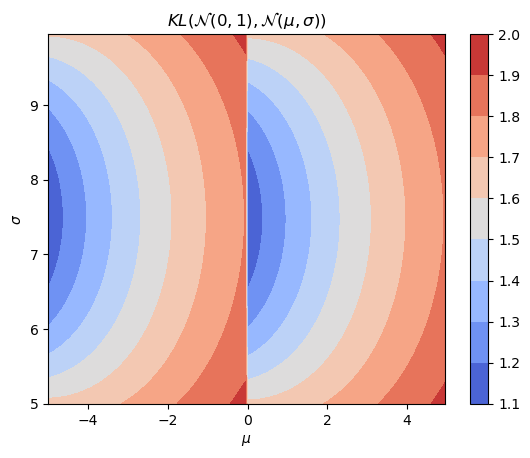

In [7]:
# Create a plot of the 2D grid
plt.contourf(xx, yy, zz, cmap="coolwarm")

# Add labels and a title to the plot
plt.xlabel("$\mu$")
plt.ylabel("$\sigma$")
plt.title(f"$KL(\mathcal{{N}}(0, 1), \mathcal{{N}}(\mu, \sigma))$")

plt.colorbar()
# Display the plot
plt.show()